# Кластеризация
Существуют задачи, когда мы имеем данные, но целевая переменная (target variable) нам не задана, т.е. принадлежность объектов к каким-либо классам не дана. В таком случае мы решаем задачу *кластеризации*, которая относится к разделу *обучения без учителя* (unsupervised learning). Задачей является построение алгоритма, который позволит распределить исходные данные на *кластеры*, т.е. объекты с похожими свойствами.

Зачем это нужно? Цели могут быть разными:
- Сделать дальнейшую работу с данными удобнее и проще; работать с каждым кластером в отдельности
- Задача сжатия данных (оставлять только типичного представителя из каждого кластера)
- Построить иерархию множества (задача таксономии: крупные кластеры делятся на более мелкие, те в свою очередь также дробятся и т.д.)
- Нахождение объектов, не относящихся ни к одному из кластеров

In [1]:
# Сгенерируем данные
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16}) # Для изменения размера шрифта на графиках
import numpy as np


X, y_true = make_blobs(n_samples=800, centers=10,
                       cluster_std=1.00, random_state=0)
X = X[:, ::-1]

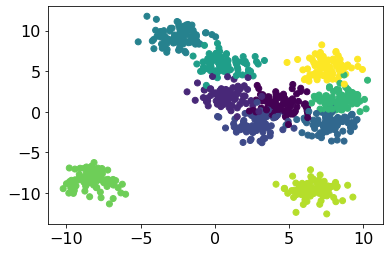

In [2]:
plt.scatter(X[:, 0], X[:, 1], c=y_true)

Существуют разные алгоритмы кластеризации, рассмотрим один из самых популярных, а именно **метод k-средних** (**k-means**). Алгоритм выглядит следующим образом:
1) Задаются начальные координаты центров кластеров. В самом простом случае - случайным образом.
2) Для каждого $x_i$ вычисляются расстояния до центров кластеров. Относим $x_i$ к ближайшему кластеру.
3) Вычисляются новые координаты центров: для каждого кластера считаем среднее значение по всем объектам, которые принадлежат данному кластеру. 
4) Повторяем шаги 2-3 до выполнения какого-либо условия (кол-во итераций, желаемая точность и т.д.)


In [3]:
num_clust = 10
num_iter = 50
# Зададим начальные центры кластеров (центроиды)
centers = np.zeros((num_clust, 2))

mu_data = np.mean(X, axis=0)
# x0_min, x0_max = (min(X[:, 0])), (max(X[:, 0]))
# x1_min, x1_max = (min(X[:, 1])), (max(X[:, 1]))
for ii in range(num_clust):
    centers[ii, 0] = mu_data[0] + np.random.randn()*1.5
    centers[ii, 1] = mu_data[1] + np.random.randn()*1.5

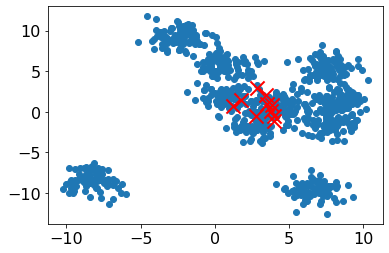

In [4]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(centers[:, 0], centers[:, 1], marker='x', lw=2, color='r', s=200)

In [5]:
def euclid_dist(x0, x1):
    return np.sqrt(((x0-x1)**2).sum())

iteration = 0
while iteration < num_iter:
    y_pred = []
    for obj in X:
        # Для каждого объекта считаем расстояние до центроида
        dists = list(map(lambda y: euclid_dist(obj, y), centers))
        # Относим каждый X к ближайшему центру
        y_pred.append(np.argmin(dists))

    y_pred = np.array(y_pred)
    # Обновляем координаты центров, вычисляя среднее значение по всем X,
    # принадлежащим к каждому из кластеров
    for ii in range(num_clust):
        centers[ii, :] = np.mean(X[y_pred==ii, :], axis=0)
        
    iteration += 1

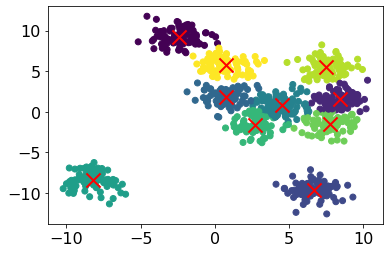

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.scatter(centers[:, 0], centers[:, 1], marker='x', lw=2, color='r', s=200)

Как и в предыдущих задачах мы хотим как-то оценить то, насколько хорошо алгоритм осуществляет кластеризацию. В качестве такого функционала можно использовать *сумму внутрикластерных расстояний*, которая должна быть минимальна:
$$\Phi_0 =\sum\limits_{y\in Y} \frac{1}{|K_y|}\sum\limits_i \rho^2(x_i, \mu_y) \rightarrow min, $$
где $|K_y|$ - количество элементов в кластере $y$, $\mu_y$ - центр кластера $y$.
Также вместе с $\Phi_0$ используют *сумму межкластерных расстояний*, которая должна быть максимальна:
$$\Phi_1 =\sum\limits_{y\in Y} \rho^2(\mu_y, \mu) \rightarrow max, $$
где $\mu$ - центр масс всей выборки. Зачастую вычисляют отношение $\Phi_0/\Phi_1 \rightarrow min$.

Добавим эти метрики в код.

In [7]:
# Сгенерируем заново центры кластеров
for ii in range(num_clust):
    centers[ii, 0] = mu_data[0] + np.random.randn()*0.5
    centers[ii, 1] = mu_data[1] + np.random.randn()*0.5
    
iteration = 0
phi_0_arr = []
phi_1_arr = []
while iteration < num_iter:
    y_pred = []
    for obj in X:
        # Для каждого объекта считаем расстояние до центроида
        dists = list(map(lambda y: euclid_dist(obj, y), centers))
        # Относим каждый X к ближайшему центру
        y_pred.append(np.argmin(dists))

    y_pred = np.array(y_pred)
    # Обновляем координаты центров, вычисляя среднее значение по всем X,
    # принадлежащим к каждому из кластеров
    for ii in range(num_clust):
        centers[ii, :] = np.mean(X[y_pred==ii, :], axis=0)
    #--------------------
    # Вычислим сумму внутрикластерных расстояний
    phi_0 = 0
    for kk in range(num_clust):
        phi_0 += euclid_dist(X[y_pred==kk, :], centers[kk, :])**2/len(X[y_pred==kk, :])
    phi_0_arr.append(phi_0)
    # Вычислим сумму межкластерных расстояний
    center_data = np.mean(X, axis=0)
    phi_1 = 0
    for kk in range(num_clust):
        phi_1 += euclid_dist(centers[kk, :], center_data)**2
    phi_1_arr.append(phi_1)
    #--------------------
        
    iteration += 1

Text(0, 0.5, '$\\Phi_0 / \\Phi_1$')

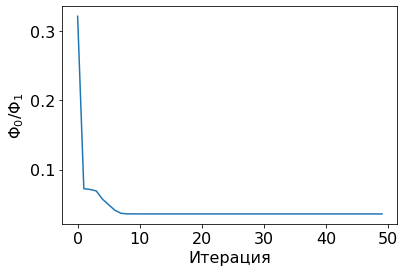

In [8]:
plt.plot(np.array(phi_0_arr)/np.array(phi_1_arr))
plt.xlabel('Итерация')
plt.ylabel('$\Phi_0 / \Phi_1$')